In [1]:
# Import packages
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import statsmodels.api as sm
import random
random.seed(42)

In [2]:
# Data Collection
# Data files and codebook from: https://www.eia.gov/consumption/residential/data/2015/index.php?view=microdata

# Load and Preview DataFrame
df = pd.read_csv('recs2015.csv')
df = df.set_index(['DOEID'])
print(df.shape)
df.head()

(5686, 758)


,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,ZBASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
DOEID,,,,,,,,,,,,,,,,,,,,,
10001,4,10,METRO,U,2,0,0,0,-2,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
10002,3,7,NONE,R,2,0,0,0,-2,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
10003,3,6,METRO,U,2,0,1,0,1,0,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
10004,2,4,MICRO,C,2,0,1,0,1,0,...,0,NaN,-2,-2,137.45,-2,-2,91.33,2,0
10005,1,2,METRO,U,2,0,1,0,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2


In [3]:
# Create feature for electric rate; total electric
df['ELRATE'] = df['DOLLAREL']/df['KWH']

### Exploratory Data Analysis

In [4]:
# check missing values
missing = df.isna().sum()
missing[missing > 0]

NGXBTU    2382
dtype: int64

Text(0, 0.5, 'Home Count')

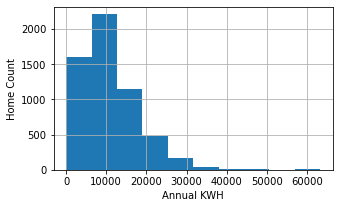

In [5]:
plt.figure(figsize=(5,3))
df['KWH'].hist()
plt.xlabel('Annual KWH')
plt.ylabel('Home Count')

In [6]:
# Low KWH
df[['KWH','TOTSQFT_EN']][df['KWH']<500]

,KWH,TOTSQFT_EN
DOEID,,
10825,59.078,768
12538,186.500,835
13365,109.157,413
14408,277.000,221


In [7]:
# High KWH
df[['KWH','TOTSQFT_EN']][df['KWH']>55000]

,KWH,TOTSQFT_EN
DOEID,,
10740,61632.172,7830
11026,57985.824,3138
11090,63216.806,5518
11969,57071.757,5733
13573,61056.868,2924
13835,57727.029,5040


<AxesSubplot:xlabel='BEDROOMS', ylabel='KWH'>

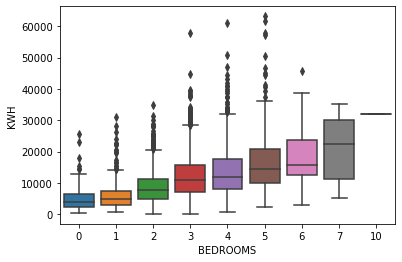

In [8]:
sns.boxplot(x=df['BEDROOMS'],y=df['KWH'])

<AxesSubplot:xlabel='YEARMADERANGE', ylabel='KWH'>

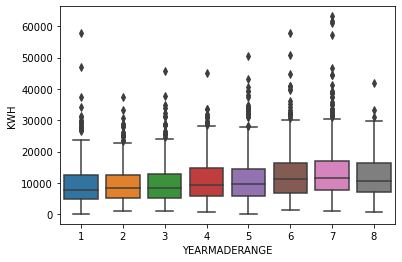

In [9]:
sns.boxplot(x=df['YEARMADERANGE'],y=df['KWH'])

<AxesSubplot:xlabel='REGIONC', ylabel='KWH'>

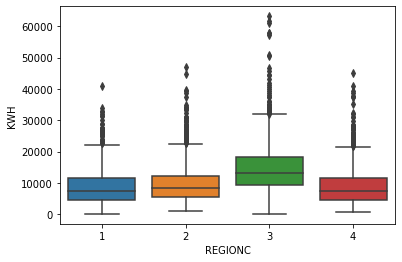

In [10]:
sns.boxplot(x=df['REGIONC'],y=df['KWH'])

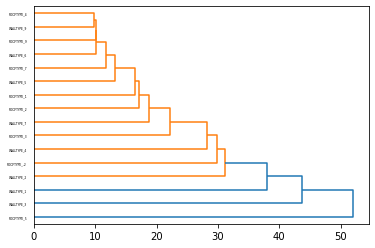

<Figure size 2160x2160 with 0 Axes>

,WALLTYPE_1,WALLTYPE_2,WALLTYPE_3,WALLTYPE_4,WALLTYPE_5,WALLTYPE_6,WALLTYPE_7,WALLTYPE_9,ROOFTYPE_-2,ROOFTYPE_1,ROOFTYPE_2,ROOFTYPE_3,ROOFTYPE_4,ROOFTYPE_5,ROOFTYPE_7,ROOFTYPE_9
DOEID,,,,,,,,,,,,,,,,
10001,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
10002,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
10003,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
10004,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
10005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
# Perform hierarchial clustering on building properties
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import normalize

X0 = pd.get_dummies(df[['WALLTYPE', 'ROOFTYPE']].astype(str))

mergings = linkage(X0.T, method='single')
dendrogram(mergings, labels=X0.columns, leaf_rotation=0, leaf_font_size=3, orientation='right')
plt.figure(figsize=(30,30))
plt.show()
plt.rcParams['figure.dpi'] = 150
X0.head()

### Data Cleaning

#### -->Eliminate Extraneous Features

In [12]:
# Read in lists of non-predictive features
impute0 = pd.read_excel('Data Cleaning/imputation_flags.xlsx')['Variable']
conversion0 = pd.read_excel('Data Cleaning/conversion_factors.xlsx')['Variable']
other_utilities0 = pd.read_excel('Data Cleaning/other_utilities.xlsx')['Variable']
estimators0 = pd.read_excel('Data Cleaning/statistical_estimators.xlsx')['Variable']
utility_costs0 = pd.read_excel('Data Cleaning/utility_costs.xlsx')['Variable']
miscellaneous0 = pd.read_excel('Data Cleaning/miscellaneous_not_used.xlsx')['Variable']
redundant0 = pd.read_excel('Data Cleaning/redundant_vars.xlsx')['Variable']
detailed0 = pd.read_excel('Data Cleaning/detailed_audit.xlsx')['Variable']

In [14]:
# Combine nonpredictive features into a single list
nonpredict = np.concatenate((impute0, conversion0, other_utilities0, estimators0, utility_costs0, miscellaneous0, redundant0, detailed0), axis=0)

In [16]:
# Drop nonpredictive features
df = df.drop(nonpredict, axis=1)

#### -->Inspect Resulting Dataframe

In [17]:
# Count missing values: {'Not applicable': -2, 'Don't Know': -9, 'Refuse': -8}

# Create mask for each type of missing value
na_mask = df.apply(lambda x: x==-2)
dk_mask = df.apply(lambda x: x==-9)
refuse_mask = df.apply(lambda x: x==-8)

In [18]:
# Count number of instances where mask is True, then filter out columns with no missing values
na = df[na_mask].count()[df[na_mask].count() > 0]
dk = df[dk_mask].count()[df[dk_mask].count() > 0]
refuse = df[refuse_mask].count()[df[refuse_mask].count() > 0]

print(str(len(na.index)) + ' columns containing \"Not applicable\" values.')
print(str(len(dk.index)) + ' columns containing \"Dont know\" values.')
print(str(len(refuse.index)) + ' columns containing \"Refuse\" values.')

99 columns containing "Not applicable" values.
19 columns containing "Dont know" values.
16 columns containing "Refuse" values.


#### -->Replace Negative Variables

In [19]:
# Replace negative values for binary variables (i.e. where negatives are "not applicable")
# Read in binary variables
binaryvars = pd.read_excel('Data Cleaning/binary_vars.xlsx')['Variable']

# Filter out negative values ("Not applicable" means approximately the same as "no" or "does not have")
df[binaryvars] = df[binaryvars].apply(lambda x: (x>0)*x)

#### -->Make Categorical Variables Dummy Variables

In [20]:
# Create dummy variables for columns with missing answers, making the missing values the base case.

# Read in list of categorical variables
cat_vars = pd.read_excel('Data Cleaning/categorical_vars.xlsx')['Variable']

In [21]:
df = pd.get_dummies(df.astype(str), columns=cat_vars, drop_first=True, prefix=cat_vars).astype('float64')

In [22]:
# Check missing values
print(df.isna().sum().max())

# Inspect DataFrame
df.shape

0


(5686, 309)

### Feature Selection

In [23]:
# Feature Selection

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [24]:
# Split Data
X = df.drop('KWH', axis=1)
names = df.drop('KWH', axis=1).columns
y = df['KWH']

#### -->Lasso Regression

In [25]:
# Lasso: Select Features

lasso = Lasso(alpha=2, max_iter=1000, normalize=True)
lasso_coef = lasso.fit(X,y).coef_
coef = pd.DataFrame(lasso_coef, names)
coef_names = coef[coef[0]>0].index
print(coef_names)
len(coef_names)

Index(['BEDROOMS', 'NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'WINDOWS', 'SWIMPOOL',
       'MONPOOL', 'MONTUB', 'BACKUP', 'NUMFRIG', 'NUMFREEZ', 'OVEN',
       'OUTGRILL', 'DWASHUSE', 'WASHLOAD', 'DRYRUSE', 'TVONWE1', 'TVONWD2',
       'INWIRELESS', 'CENACHP', 'NUMBERAC', 'GARGCOOL', 'NUMCFAN',
       'MORETHAN1H2O', 'LGTIN4', 'NHSLDMEM', 'NUMADULT', 'MONEYPY', 'SCALEB',
       'PAYHELP', 'ELWARM', 'ELFOOD', 'TOTCSQFT', 'TOTSQFT_EN', 'CDD30YR',
       'CDD65', 'OA_LAT', 'REGIONC_3', 'UATYP10_R', 'TYPEHUQ_2', 'ROOFTYPE_3',
       'ROOFTYPE_4', 'FUELPOOL_5', 'FUELTUB_21', 'FUELTUB_5', 'DRYRFUEL_5',
       'FUELHEAT_5', 'COOLTYPE_3', 'FUELH2O_5', 'WHEATSIZ_3', 'FUELH2O2_5',
       'IECC_CLIMATE_PUB_4A', 'IECC_CLIMATE_PUB_4C', 'WWACAGE_41'],
      dtype='object')


54

In [26]:
# Lasso: Regression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 41)
model = lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)

0.6277646318987413

In [27]:
# Perform cross validation
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(lasso, X, y, cv=5)
lasso_eval = np.mean(cv_results)
print(lasso_eval)

0.6199199752568768


In [28]:
#Correlation
np.corrcoef(y_pred, y_test)

array([[1.        , 0.79242814],
       [0.79242814, 1.        ]])

In [29]:
# Inspect coefficients
col = pd.DataFrame(X_test.columns)
coefs = pd.DataFrame(model.coef_)
coef_df = pd.merge(col, coefs, left_index=True, right_index=True).sort_values(by='0_y', ascending=False)
coef_df.columns = ['Feature', 'Coefficient']
coef_df.head(20)

,Feature,Coefficient
202,FUELTUB_21,9472.380974
239,FUELHEAT_5,2373.053075
89,MORETHAN1H2O,2049.300906
260,FUELH2O_8,1979.144410
258,FUELH2O_5,1718.859228
83,GARGCOOL,1123.712144
26,NUMFRIG,1115.472923
160,REGIONC_3,1043.578942
27,NUMFREEZ,1036.612560
164,UATYP10_R,805.118347


In [82]:
# Why is FUELTUB_21 (hot tubs heated by "some other fuel") most important?
print(X_train['FUELTUB_21'][X_train['FUELTUB_21']>0])

DOEID
13184    1.0
Name: FUELTUB_21, dtype: float64


In [30]:
# Create DataFrame comparing LassoRegression Predicted kWh to Actual kWh

predicted = pd.DataFrame(y_pred, columns=['Predicted']).set_index(y_test.index)
results = pd.merge(predicted, y_test, left_index=True, right_index = True)
results_sorted = results.sort_values(['KWH'])

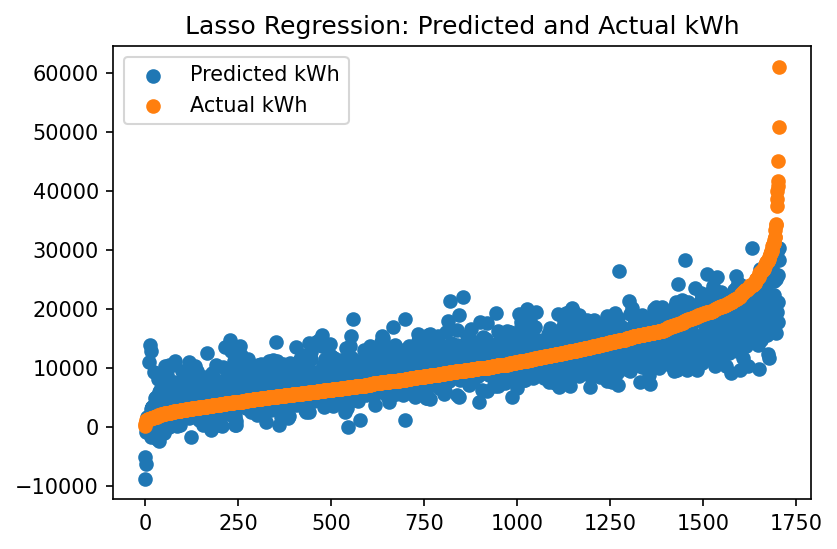

In [31]:
# Visually inspect results

_ = plt.scatter(np.arange(len(X_test)), results_sorted['Predicted'])
_ = plt.scatter(np.arange(len(X_test)), results_sorted['KWH'])
plt.legend(['Predicted kWh','Actual kWh'])
plt.title("Lasso Regression: Predicted and Actual kWh")
plt.show()

**Reuse features from Lasso regression feature selection for other models**

In [32]:
# Create new filtered dataframe for X
X = df[coef_names]

### Linear Regression

In [33]:
# Linear Regression

from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 41)
linear = LinearRegression()
model = linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
linear.score(X_test, y_test)

0.609975348390132

In [34]:
# Perform cross validation

cv_results = cross_val_score(linear, X, y, cv=5)
linear_eval = np.mean(cv_results)
print(linear_eval)

0.6079975070836949


In [35]:
#Correlation
np.corrcoef(y_pred, y_test)

array([[1.        , 0.78203625],
       [0.78203625, 1.        ]])

In [36]:
# Inspect coefficients
col = pd.DataFrame(X_test.columns)
coefs = pd.DataFrame(model.coef_)
coef_df = pd.merge(col, coefs, left_index=True, right_index=True).sort_values(by='0_y', ascending=False)
coef_df.columns = ['Feature', 'Coefficient']
coef_df.head(20)

,Feature,Coefficient
43,FUELTUB_21,17636.505891
46,FUELHEAT_5,2588.417730
23,MORETHAN1H2O,2230.387057
21,GARGCOOL,2021.274501
48,FUELH2O_5,1921.860494
37,REGIONC_3,1667.923417
42,FUELPOOL_5,1450.978693
52,IECC_CLIMATE_PUB_4C,1421.626115
10,NUMFREEZ,1244.041321
41,ROOFTYPE_4,1188.254710


In [37]:
# Create DataFrame comparing LinearRegression Predicted kWh to Actual kWh

predicted = pd.DataFrame(y_pred, columns=['Predicted']).set_index(y_test.index)
results = pd.merge(predicted, y_test, left_index=True, right_index = True)
results_sorted = results.sort_values(['KWH'])

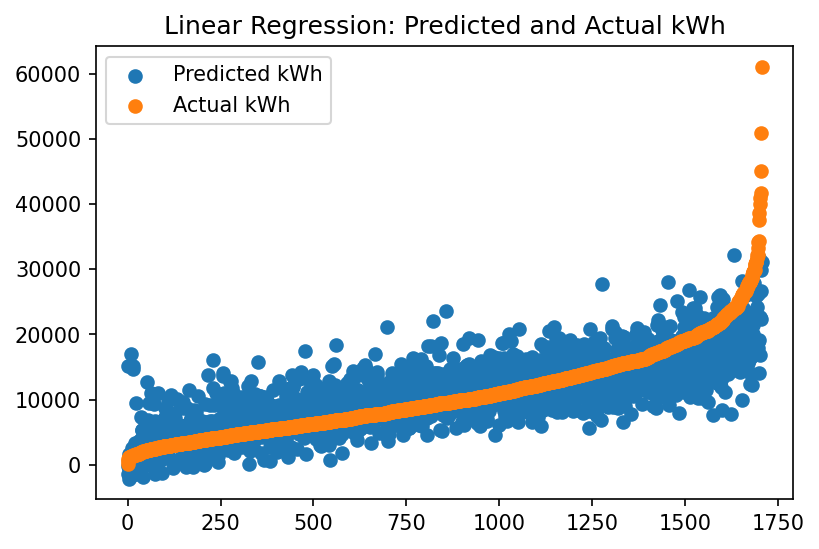

In [38]:
# Visually inspect results

_ = plt.scatter(np.arange(len(X_test)), results_sorted['Predicted'])
_ = plt.scatter(np.arange(len(X_test)), results_sorted['KWH'])
plt.legend(['Predicted kWh','Actual kWh'])
plt.title("Linear Regression: Predicted and Actual kWh")
plt.show()

### Ridge Regression

In [39]:
# Ridge Regression

from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
ridge = Ridge(alpha=0.1, normalize=True)
model = ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge.score(X_test, y_test)

0.6365047448486632

In [40]:
# Perform cross validation

cv_results = cross_val_score(ridge, X, y, cv=5)
ridge_eval =  np.mean(cv_results)
print(ridge_eval)

0.6088276743353143


In [41]:
np.corrcoef(y_pred, y_test)

array([[1.        , 0.79816884],
       [0.79816884, 1.        ]])

In [42]:
# Inspect coefficients
col = pd.DataFrame(X_test.columns)
coefs = pd.DataFrame(model.coef_)
coef_df = pd.merge(col, coefs, left_index=True, right_index=True).sort_values(by='0_y', ascending=False)
coef_df.columns = ['Feature', 'Coefficient']
coef_df.head(20)

,Feature,Coefficient
43,FUELTUB_21,17018.011610
21,GARGCOOL,3072.800787
46,FUELHEAT_5,2328.312619
42,FUELPOOL_5,2237.268082
23,MORETHAN1H2O,2031.139290
48,FUELH2O_5,1821.905131
52,IECC_CLIMATE_PUB_4C,1642.941338
41,ROOFTYPE_4,1619.960033
37,REGIONC_3,1598.913386
50,FUELH2O2_5,1520.438515


In [43]:
# Create DataFrame comparing RidgeRegression Predicted kWh to Actual kWh

predicted = pd.DataFrame(y_pred, columns=['Predicted']).set_index(y_test.index)
results = pd.merge(predicted, y_test, left_index=True, right_index = True)
results_sorted = results.sort_values(['KWH'])

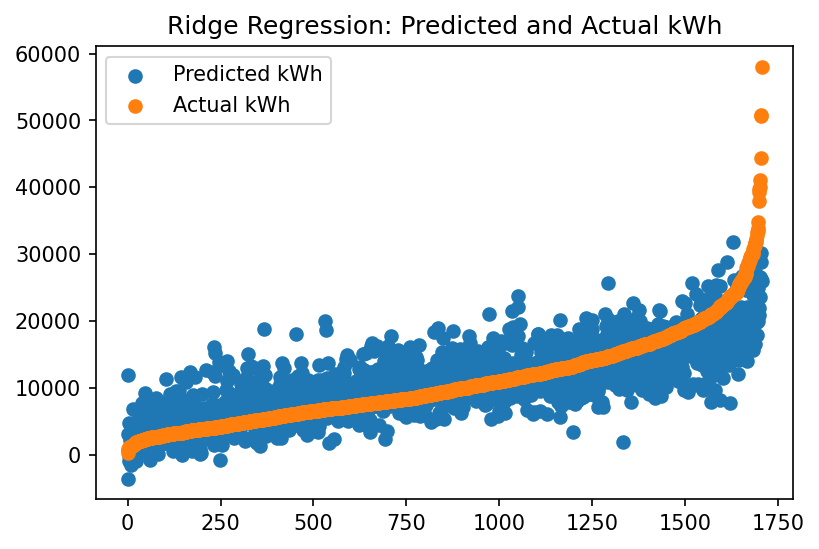

In [44]:
# Visually inspect results
_ = plt.scatter(np.arange(len(X_test)), results_sorted['Predicted'])
_ = plt.scatter(np.arange(len(X_test)), results_sorted['KWH'])
plt.legend(['Predicted kWh','Actual kWh'])
plt.title("Ridge Regression: Predicted and Actual kWh")
plt.show()

In [45]:
print('Cross Validation Results')
print('Lasso_Regression:', lasso_eval)
print('Linear_Regression:', linear_eval)
print('Ridge_Regression:', ridge_eval)

Cross Validation Results
Lasso_Regression: 0.6199199752568768
Linear_Regression: 0.6079975070836949
Ridge_Regression: 0.6088276743353143


Summary

I used Lasso Regression for feature selection. A higher alpha in the Lasso regression reduces the number of features, while a lower alpha preserves features. I manually tested the results of different alphas and determined that alpha=2 preserves most of the accuracy while substantially reducing number of features (down to 54 from the original 307 post manual feature inspection and deletion).

I then performed model fitting and 5-fold cross-validation for a lasso, linear, and ridge regression model. All produced similar cross-validation scores (shown above) and had correlation coefficients of 0.77 to 0.78 between predicted kWh and test-set kWh.

The linear regression model may be the best choice for its interpretability, even though lasso and ridge regression produced very slight improvements in cross-validation scores.